In [104]:
# dataset url https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset# download model from https://huggingface.co/thefcraft/lungs-disease-prediction/tree/main

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms#, models
from torch.utils.data import DataLoader, Dataset, random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
# Define your dataset class
class TBDataset(Dataset):
    def __init__(self, path='TB_Chest_Radiography_Database', transform=None):
        self.transform = transform
        
        # List all TB images
        tb_path = os.path.join(path, 'Tuberculosis')
        tb_images = [os.path.join(tb_path, img) for img in os.listdir(tb_path)]
        
        # List a subset of normal images (first 1000) as i have 765 images of tb so to balance the number i use 1000 normal images
        ntb_path = os.path.join(path, 'Normal')
        ntb_images = [os.path.join(ntb_path, img) for img in os.listdir(ntb_path)[:1000]]
        
        # Combine into a list of tuples (image_path, label)
        self.db = [(img, 1) for img in tb_images] + [(img, 0) for img in ntb_images]
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, idx):
        img_path, label = self.db[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        
        
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
dataset = TBDataset(transform=transform)
split = 0.8
train_size = int(split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
for x,y in train_loader:
    break
x.shape, y.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 64 * 64)  # Flatten the output for FC layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [9]:
model = Model().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        labels = labels.unsqueeze(dim=1).to(torch.float32).to(device)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.3252
Epoch [2/30], Loss: 0.1786
Epoch [3/30], Loss: 0.1596
Epoch [4/30], Loss: 0.1404
Epoch [5/30], Loss: 0.1233
Epoch [6/30], Loss: 0.1108
Epoch [7/30], Loss: 0.1141
Epoch [8/30], Loss: 0.1047
Epoch [9/30], Loss: 0.0962
Epoch [10/30], Loss: 0.1345
Epoch [11/30], Loss: 0.0833
Epoch [12/30], Loss: 0.0891
Epoch [13/30], Loss: 0.0879
Epoch [14/30], Loss: 0.0733
Epoch [15/30], Loss: 0.0794
Epoch [16/30], Loss: 0.0603
Epoch [17/30], Loss: 0.0650
Epoch [18/30], Loss: 0.0620
Epoch [19/30], Loss: 0.0477
Epoch [20/30], Loss: 0.0642
Epoch [21/30], Loss: 0.0448
Epoch [22/30], Loss: 0.0634
Epoch [23/30], Loss: 0.0520
Epoch [24/30], Loss: 0.0410
Epoch [25/30], Loss: 0.0396
Epoch [26/30], Loss: 0.0464
Epoch [27/30], Loss: 0.0429
Epoch [28/30], Loss: 0.0450
Epoch [29/30], Loss: 0.0282
Epoch [30/30], Loss: 0.0562


In [11]:
torch.save(model.state_dict(), '30_tb_binary_classification_model.pth')

In [ ]:
model = Model().to(device)
model.load_state_dict(torch.load('30_tb_binary_classification_model.pth'))
model.eval()

In [12]:
model.eval()
with torch.no_grad():
    total = 0
    currect = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        
        labels = labels.numpy()
        outputs = (outputs.cpu().squeeze().numpy() > 0.5).astype(np.int64)
        currect += (outputs == labels).sum()
        total += outputs.shape[0]
        
        
print(f"ACC : {currect/total}")

ACC : 0.9764705882352941


tensor([[0.9946]])


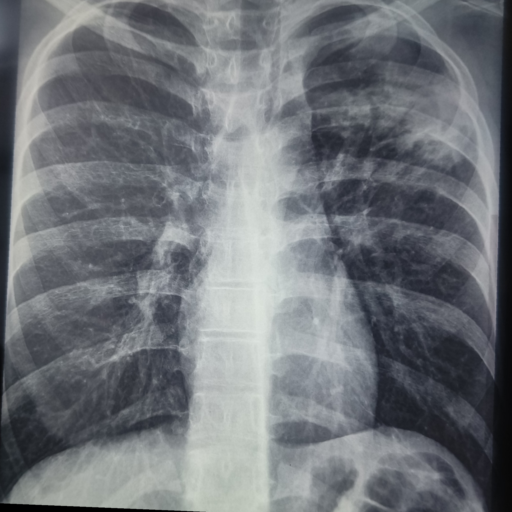

In [103]:
def infer(img_path):
    image = Image.open(img_path).convert('RGB')
    # image = image.resize((512, 512))
    image = transforms.RandomRotation(10)(image)
    image = transforms.RandomResizedCrop(512, scale=(0.8, 1.0))(image)
    img = image
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    return image.unsqueeze(dim=0), img

img_path = r"C:\ThefCraft\AI\cnn\lungs\mine\IMG20240228192513.jpg"
x, img = infer(img_path)
with torch.no_grad():
    pred = model(x.to(device)).cpu()
print(pred)
img

tensor([[0.0572]])


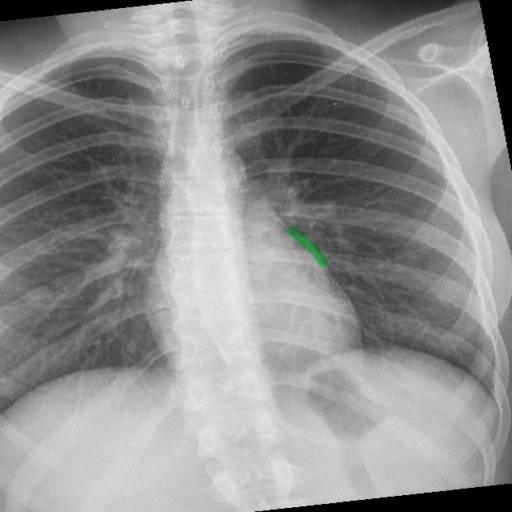

In [101]:
img_path = r"C:\ThefCraft\AI\cnn\lungs\mine\normal.jpg"
x, img = infer(img_path)
with torch.no_grad():
    pred = model(x.to(device)).cpu()
print(pred)
img

tensor([[0.0392]])


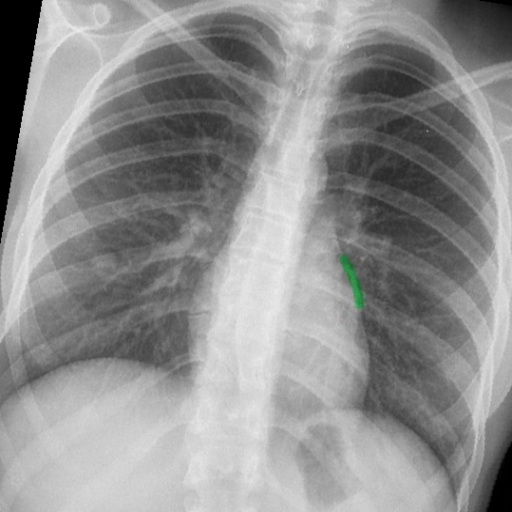

In [106]:
model = Model().to(device)
model.load_state_dict(torch.load('30_tb_binary_classification_model.pth'))
model.eval()
img_path = r"C:\ThefCraft\AI\cnn\lungs\mine\normal.jpg"
x, img = infer(img_path)
with torch.no_grad():
    pred = model(x.to(device)).cpu()
print(pred)
img